# Hybrid Model: CNN & Transformers
Following the results of the CNN models, we wanted to see if we could improve results even further.

We will use a pre-trained CNN (MobileNetV2) and add a transformer layer in order to see if this improves the results of the model.

# Importing Libraries:

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import hashlib
import cv2
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Import Training, Validation, and Testing Datasets:

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Change directory to 'DATASCI207_FinalProject'
os.chdir('/content/drive/My Drive/DATASCI207_FinalProject')

In [4]:
# Load the Pre-Processed Training Data:
X_train = np.load('X_train.npy')
Y_train = np.load('Y_train.npy')

# Load the Pre-Processed Validation Data:
X_val = np.load('X_val.npy')
Y_val = np.load('Y_val.npy')

# Load the Pre-Processed Testing Data:
X_test = np.load('X_test.npy')
Y_test = np.load('Y_test.npy')

# Building a Hybrid Model:

Build the MobileNetV2 model, with added transformer layer:

In [5]:
def hybrid_model(initial_epochs=20, fine_tuning_epochs=20):
  '''Function to create and compile a hybrid (CNN & Transformer) model. The model
     includes a pre-trained CNN model (MobileNetV2) with an added transformer layer.
     Input: hyperparameters, including: number of filters, kernel size, stride size
     max pooling size, dropout rate, and number of epochs.

     Output: compiled model with performance results.'''

  early_stopping = EarlyStopping(
    monitor='val_accuracy',
    verbose=1,
    patience=4,
    mode='max',
    restore_best_weights=True
  )

  # Learning rate reduction callback
  reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=2, min_lr=0.00001)

  # Load the pre-trained MobileNetV2 model:
  base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
  base_model.trainable = False  # initially freeze the base model

  # Add custom layers on top of the pre-trained model:
  inputs = tf.keras.Input(shape=(224, 224, 3))
  x = base_model(inputs, training=False)

  # Reshape the output of the base model to fit the transformer layer input requirements:
  x = tf.keras.layers.Reshape((7 * 7, 1280))(x)

  # Add transformer layer:
  attention_output = tf.keras.layers.MultiHeadAttention(num_heads=4, key_dim=1280)(x, x)
  x = tf.keras.layers.Reshape((7, 7, 1280))(attention_output)

  # Global average pooling and the rest of the custom layers:
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = tf.keras.layers.Dropout(0.5)(x)  # Increased dropout rate
  x = tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)  # Add L2 regularization
  outputs = tf.keras.layers.Dense(4, activation='softmax')(x)

  model = tf.keras.Model(inputs, outputs)

  # Compile the model:
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

  # Print model summary
  model.summary()

  # data augmentation
  datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
  )

  # Apply data augmentation to the training dataset:
  train_generator = datagen.flow(X_train, Y_train, batch_size=32)

  # Train the model:
  model_fit = model.fit(train_generator,
                        epochs=initial_epochs,
                        validation_data=(X_val, Y_val),
                        callbacks=[early_stopping,
                        reduce_lr])

  # Unfreeze some layers of the base model for fine-tuning:
  base_model.trainable = True
  fine_tune_at = 100
  for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

  # Recompile the model with a lower learning rate:
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

  # Continue training with fine-tuning:
  model_fit = model.fit(train_generator,
                      epochs=fine_tuning_epochs,
                      validation_data=(X_val, Y_val),
                      callbacks=[early_stopping,
                      reduce_lr])

  # Evaluate the model:
  _, train_accuracy = model.evaluate(X_train, Y_train)
  print('Training Accuracy: {}'.format(train_accuracy))

  _, val_accuracy = model.evaluate(X_val, Y_val)
  print('Validation Accuracy: {}'.format(val_accuracy))

  # Plot the results:
  # Gather the accuracy and loss values from the model:
  model_training_accuracies = model_fit.history['accuracy']
  model_val_accuracies = model_fit.history['val_accuracy']

  model_training_loss = model_fit.history['loss']
  model_val_loss = model_fit.history['val_loss']

  # Calculate the number of epochs for the x-axis:
  num_epochs = np.arange(1, len(model_training_accuracies) + 1)

  fig, ax = plt.subplots(nrows=2, ncols=1)

  # Plot the model accuracies
  ax[0].plot(num_epochs, model_training_accuracies, label='Training Accuracy')
  ax[0].plot(num_epochs, model_val_accuracies, label='Validation Accuracy')

  ax[0].set_title('Training & Validation Accuracies for Baseline Model')
  ax[0].legend()

  ax[1].plot(num_epochs, model_training_loss, label='Training Loss')
  ax[1].plot(num_epochs, model_val_loss, label='Validation Loss')

  ax[1].set_title('Training & Validation Losses for Baseline Model')
  ax[1].legend()

  plt.tight_layout()
  plt.show()

  return model

9406464/9406464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)           2257984   ['input_2[0][0]']             
 tional)                                                                                          
                                                                                                  
 reshape (Reshape)           (None, 49, 1280)             0         ['mobilenetv2_1.00_224[0][0]']
                                                                                                  
 multi_head_attention (Mult  (N

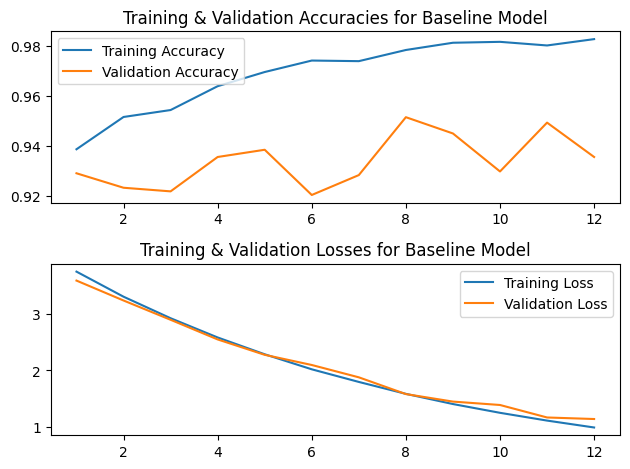

In [6]:
hybrid_cnn_transformer_model = hybrid_model(initial_epochs=20, fine_tuning_epochs=20)

We find that the hybrid CNN + Transformer model indeed performs better than both Complex CNN models, with validation accuracies in the 95% range. Now, we will test all models against unseen (test) data for final performance metrics.

# Save Hybrid Model:

In [7]:
# Save the hybrid model:
hybrid_cnn_transformer_model.save('/content/drive/My Drive/DATASCI207_FinalProject/hybrid_transformer_cnn_model.keras')